In [2]:
##Attempt at using sigkernel with data
import apache_beam

In [6]:
import os
import weatherbench2
import xarray as xr
import numpy as np
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config

In [7]:
forecast_path = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'

In [8]:
forecasts = xr.open_zarr(forecast_path)
observations = xr.open_zarr(obs_path)

In [ ]:
#Goal is to have batch as model, length x as time, value as lat/long flattened

In [41]:
#Test with pred_timedelta = 0

forecastssel = forecasts['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,0,:,:]
savedfor = forecasts0.values

In [42]:
observationsel = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
savedobs = observationsel[::2,:,:].values

In [43]:
savedobs.shape
reshabedobs = savedobs.reshape(-1,64*32)
reshabedobs.shape

#print(savedobs[0,1,0])  #2d position flattened to 1d, go through every latitude for 0 long, then every lat for 1 long etc.
#print(reshabedobs[0,32])
csrsobs = np.cumsum(reshabedobs,axis=0) #Culmative sum goes elementwise 

In [44]:
savedfor.shape
reshavedfors = savedfor.reshape(20,50,64*32)
csrsfor = np.cumsum(reshavedfors,axis=0)

#print(savedfor[0,2,0,1]+savedfor[1,2,0,1]+savedfor[2,2,0,1])
#csrsfor[2,2,1]
csrsfor.shape


(20, 50, 2048)

In [45]:
print("Obs shape:", csrsobs.shape)
print("Fors shape:", csrsfor.shape)

csrsobsex = np.expand_dims(csrsobs, axis = 0)
csrsforsw = np.transpose(csrsfor, (1,0,2))


print("Final Obs shape:", csrsobsex.shape)
print("Final Fors shape:", csrsforsw.shape)

print(csrsobsex.mean())
print(csrsforsw.mean())


Obs shape: (20, 2048)
Fors shape: (20, 50, 2048)
Final Obs shape: (1, 20, 2048)
Final Fors shape: (50, 20, 2048)
566411.25
566381.0


In [11]:
csrsobs

array([[  49846.934,   50196.53 ,   50391.094, ...,   49238.684,
          48659.176,   48309.336],
       [  99582.08 ,  100317.56 ,  100602.34 , ...,   98387.58 ,
          97347.555,   96948.   ],
       [ 149389.56 ,  150369.94 ,  150675.31 , ...,  147365.78 ,
         146372.73 ,  145847.44 ],
       ...,
       [ 902296.25 ,  908305.7  ,  910008.2  , ...,  887298.8  ,
         889337.25 ,  888369.3  ],
       [ 953454.6  ,  959792.7  ,  961143.75 , ...,  937034.1  ,
         939557.7  ,  939232.4  ],
       [1004562.3  , 1011216.9  , 1012094.06 , ...,  986696.44 ,
         989878.25 ,  989886.   ]], dtype=float32)

In [15]:
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython

In [13]:
## Date processed completed, beggining
X = torch.tensor(csrsforsw, dtype=torch.double)
y = torch.tensor(csrsobsex, dtype=torch.double)

In [21]:
static_kernel = sigkernel.RBFKernel(sigma=10000)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

K_XX = signature_kernel.compute_Gram(X,X)
K_Xy = signature_kernel.compute_Gram(X, y)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX)
print(K_Xy) #
print("K_XX_m:", K_XX_m) #Expected self similirity of predictions... 
print(-2. * torch.mean(K_Xy)) #Expected similarity between prediction and observation
print(K_XX_m -(2.*torch.mean(K_Xy)))

#Feels like there are rounding errors

tensor([[1.5280e+05, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.5278e+05, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.5278e+05,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.5276e+05, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.5280e+05,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.5300e+05]], dtype=torch.float64)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [ ]:
static_kernel = sigkernel.Linear_ID_Kernel() #LinearKernel or Linear_ID_Kernel goes to infinity
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

K_XX = signature_kernel.compute_Gram(X,X)
K_Xy = signature_kernel.compute_Gram(X, y)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX)
print(K_Xy) #
print("K_XX_m:", K_XX_m) #Expected self similirity of predictions... 
print(-2. * torch.mean(K_Xy)) #Expected similarity between prediction and observation
print(K_XX_m -(2.*torch.mean(K_Xy)))


tensor([[inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        ...,
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf],
        [inf, inf, inf,  ..., inf, inf, inf]], dtype=torch.float64)
tensor([[inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],
        [inf],

In [22]:
signature_kernel.compute_scoring_rule(X,y)

tensor(-1., dtype=torch.float64)

In [16]:
#Trying a mean shift? #Used minimum, didn't work

forecastssel = forecasts['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,0,:,:]
savedfor = forecasts0.values

observationsel = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
savedobs = observationsel[::2,:,:].values

#Shifting everything down by minimum value
minvalue = np.array([savedobs.min(),savedfor.min()]).min()
print(minvalue)
print(savedobs.mean())
savedobsshift = savedobs - minvalue
savedforshift = savedfor - minvalue

savedobsshift.shape
reshabedobs = savedobsshift.reshape(-1,64*32)
reshabedobs.shape

# #print(savedobs[0,1,0])  #2d position flattened to 1d, go through every latitude for 0 long, then every lat for 1 long etc.
# #print(reshabedobs[0,32])
csrsobs = np.cumsum(reshabedobs,axis=0) #Culmative sum goes elementwise 

# savedfor.shape
reshavedfors = savedforshift.reshape(20,50,64*32)
csrsfor = np.cumsum(reshavedfors,axis=0)

# #print(savedfor[0,2,0,1]+savedfor[1,2,0,1]+savedfor[2,2,0,1])
# #csrsfor[2,2,1]
# csrsfor.shape

print("Obs shape:", csrsobs.shape)
print("Fors shape:", csrsfor.shape)

csrsobsex = np.expand_dims(csrsobs, axis = 0)
csrsforsw = np.transpose(csrsfor, (1,0,2))

print("Final Obs shape:", csrsobsex.shape)
print("Final Fors shape:", csrsforsw.shape)



45149.05
53974.15
Obs shape: (20, 2048)
Fors shape: (20, 50, 2048)
Final Obs shape: (1, 20, 2048)
Final Fors shape: (50, 20, 2048)


In [53]:
X = torch.tensor(csrsforsw, dtype=torch.double)
y = torch.tensor(csrsobsex, dtype=torch.double)

static_kernel = sigkernel.RBFKernel(sigma=2)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

K_XX = signature_kernel.compute_Gram(X,X)
K_Xy = signature_kernel.compute_Gram(X, y)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX)
print(K_Xy) #
print("K_XX_m:", K_XX_m) #Expected self similirity of predictions... 
print(-2. * torch.mean(K_Xy)) #Expected similarity between prediction and observation
print(K_XX_m -(2.*torch.mean(K_Xy)))

tensor([[8.7792e+04, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 8.3319e+04, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 8.4337e+04,  ..., 1.0000e+00, 1.0000e+00,
         1.0000e+00],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.1022e+04, 1.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 8.2747e+04,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 1.0000e+00,
         1.0720e+05]], dtype=torch.float64)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
     

In [ ]:
#Trying a divid by maximum shift? Does generate real value: does it work? 

forecastssel = forecasts['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,0,:,:]
savedfor = forecasts0.values

observationsel = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
savedobs = observationsel[::2,:,:].values

#Shifting everything down by minimum value
maxvalue = np.array([savedobs.max(),savedfor.max()]).max()
#maxvalue = 58758.746
print(maxvalue)
print(savedobs.mean())
savedobsshift = savedobs/maxvalue
savedforshift = savedfor/maxvalue

savedobsshift.shape
reshabedobs = savedobsshift.reshape(-1,64*32)
reshabedobs.shape

# #print(savedobs[0,1,0])  #2d position flattened to 1d, go through every latitude for 0 long, then every lat for 1 long etc.
# #print(reshabedobs[0,32])
csrsobs = np.cumsum(reshabedobs,axis=0) #Culmative sum goes elementwise 

# savedfor.shape
reshavedfors = savedforshift.reshape(20,50,64*32)
csrsfor = np.cumsum(reshavedfors,axis=0)

# #print(savedfor[0,2,0,1]+savedfor[1,2,0,1]+savedfor[2,2,0,1])
# #csrsfor[2,2,1]
# csrsfor.shape

print("Obs shape:", csrsobs.shape)
print("Fors shape:", csrsfor.shape)

csrsobsex = np.expand_dims(csrsobs, axis = 0)
csrsforsw = np.transpose(csrsfor, (1,0,2))

print("Final Obs shape:", csrsobsex.shape)
print("Final Fors shape:", csrsforsw.shape)

58758.746
53974.15
Obs shape: (20, 2048)
Fors shape: (20, 50, 2048)
Final Obs shape: (1, 20, 2048)
Final Fors shape: (50, 20, 2048)


In [ ]:
#When maxvalue set to over the extra 15 days as follows, method matches for lag 0 
signature_kernel.compute_scoring_rule(X,y).item()

-80523.50405149849

In [18]:
X = torch.tensor(csrsforsw, dtype=torch.double)
y = torch.tensor(csrsobsex, dtype=torch.double)

static_kernel = sigkernel.RBFKernel(sigma=2)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

K_XX = signature_kernel.compute_Gram(X,X)
K_Xy = signature_kernel.compute_Gram(X, y)
K_XX_m = (torch.sum(K_XX) - torch.sum(torch.diag(K_XX))) / (K_XX.shape[0] * (K_XX.shape[0] - 1.))
print(K_XX)
print(K_Xy) #
print("K_XX_m:", K_XX_m) #Expected self similirity of predictions... 
print(-2. * torch.mean(K_Xy)) #Expected similarity between prediction and observation
print(K_XX_m -(2.*torch.mean(K_Xy)))

tensor([[153677.1668, 141831.0625, 145261.9578,  ..., 142337.7196,
         145606.2026, 146748.5873],
        [141831.0625, 153677.1669, 145893.8163,  ..., 147020.9039,
         142580.1742, 144588.5203],
        [145261.9578, 145893.8163, 153677.1669,  ..., 145056.4159,
         145686.2982, 146244.4211],
        ...,
        [142337.7196, 147020.9039, 145056.4159,  ..., 153677.1669,
         142756.5391, 144857.7361],
        [145606.2026, 142580.1742, 145686.2982,  ..., 142756.5391,
         153677.1668, 145791.2138],
        [146748.5873, 144588.5203, 146244.4211,  ..., 144857.7361,
         145791.2138, 153677.1675]], dtype=torch.float64)
tensor([[111963.1239],
        [113400.2121],
        [112101.8209],
        [111965.0228],
        [112209.0951],
        [111869.1087],
        [111856.3950],
        [115466.1790],
        [113719.4448],
        [112118.7457],
        [113137.7077],
        [111740.7530],
        [111712.5862],
        [111781.7241],
        [111070.7840],
  

In [38]:
##Now on multiple lags:

forecastssel = forecasts['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-10'))
forecasts0 = forecastssel[:,:,:,:,:]
savedfor = forecasts0.values

forecasts0

<xarray.DataArray 'geopotential' (time: 20, number: 50,
                                  prediction_timedelta: 61, longitude: 64,
                                  latitude: 32)>
dask.array<getitem, shape=(20, 50, 61, 64, 32), dtype=float32, chunksize=(4, 50, 1, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 -87.19 -81.56 ... 81.56 87.19
    level                 int32 500
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * number                (number) int32 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-10T12:...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [39]:
observationsel = observations['geopotential'].sel(level = 500, time = slice('2020-01-01', '2020-01-25')) #Plus 15 days
savedobs = observationsel.values


In [47]:
kernelscores = []
#Non weighted
#61 predictlags, just doing 60
#Can't sum observations beforehand (well can but would have to split it into either the 0-12 or 6-18 paths)


maxvalue = np.array([savedobs.max(),savedfor.max()]).max()
savedobsshift = savedobs/(20*maxvalue)
savedforshift = savedfor/(20*maxvalue)

#print(maxvalue)
#print(savedobsshift.shape)
static_kernel = sigkernel.RBFKernel(sigma=2)
dyadic_order = 2
signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order)

for i in range(60):
        fors = savedforshift[:,:,i,:,:]
        obs = savedobsshift[i:i-60,:,:][::2,:,:]

        obs = obs.reshape(-1,64*32)
        obs = np.cumsum(obs,axis=0)

        fors = fors.reshape(20,50,64*32)
        fors = np.cumsum(fors,axis=0)

        obs = np.expand_dims(obs, axis = 0)
        fors = np.transpose(fors, (1,0,2))

        X = torch.tensor(fors, dtype=torch.double)
        y = torch.tensor(obs, dtype=torch.double)

        val = signature_kernel.compute_scoring_rule(X,y).item()
        print(val)
        kernelscores.append(val)


-133235.46056294744
-133200.14128744707
-133082.86880650365
-133040.42808708717
-132905.90511333974
-132767.6429333775
-132654.62494567022
-132420.91340222448
-132244.8482090275
-132005.53441547535
-131620.93153636038
-131396.46935077733
-130850.4318567297
-130439.25141615863
-129607.91194283086
-129220.98209563334
-128178.49667264399
-127592.74438121507
-126317.99462302604
-125588.37956026629
-124053.53655726444
-123142.3954310006
-121304.24291619932
-120004.12454632533
-117663.05375809663
-115851.15013513502
-112729.12141544124
-110190.45560634536
-106252.55126230046
-103020.8606322382
-98541.13267966146
-95009.08181462508
-90287.4987364932
-86728.82346700794
-82373.02221499581
-78978.8884594571
-74735.092407249
-71472.39037405737
-67652.13715296655
-64746.28761823359
-61247.593679339
-58427.15874300443
-54887.529257288814
-52280.035743955406
-49105.37151641607
-47158.48157490528
-44719.17052196333
-43535.93985107816
-41885.357312861204
-41165.45750646616
-39811.4017333223
-39060.696

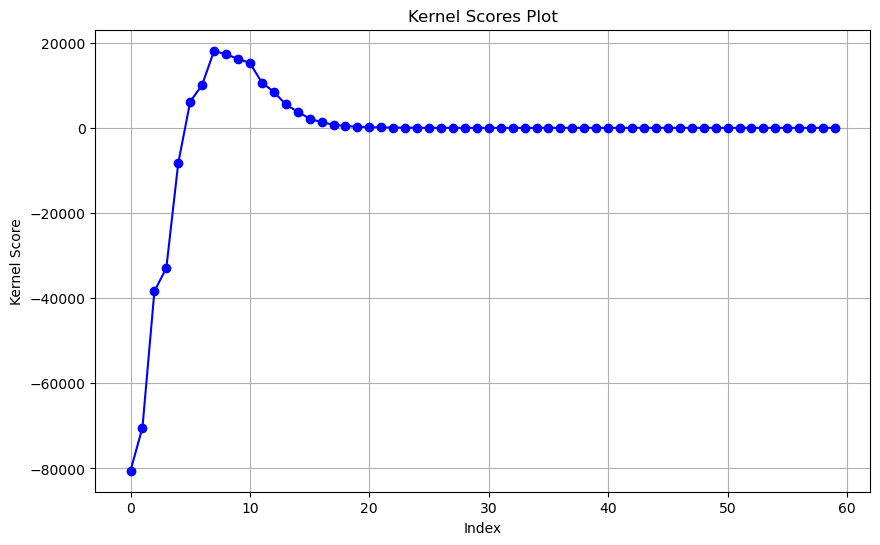

In [ ]:
import matplotlib.pyplot  as plt

kernelscores
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(kernelscores, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

#Getting closer and closer to -1, is this approaching the same rounding error? But surely paths are becoming different

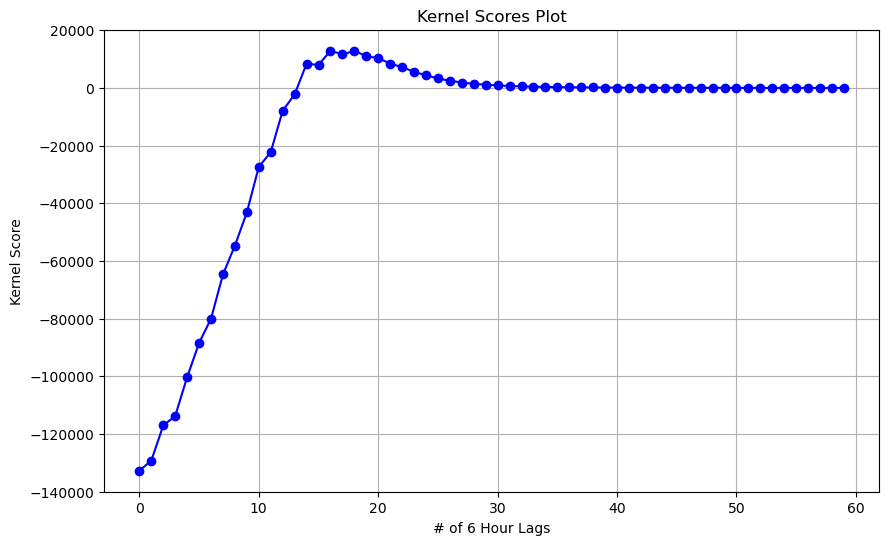

In [ ]:
kernelscores
#Diving by 2*max, looks better?
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(kernelscores, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

#Largely reduces the alternating 0-12, 6-18 hour zigzag, still can be seen slightly but not causing changed minimum

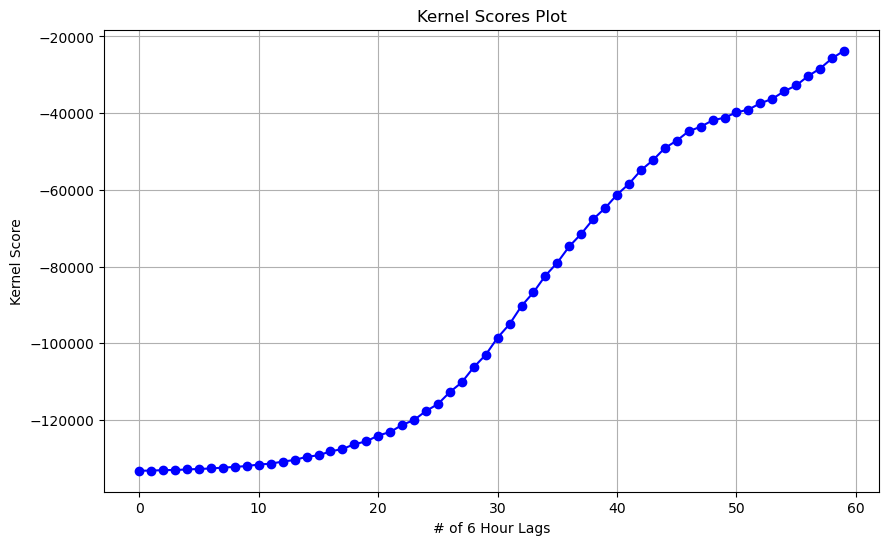

In [ ]:
#Dividing by 20*max
kernelscores
plt.figure(figsize=(10, 6))  # Set the figure size if needed
plt.plot(kernelscores, marker='o', linestyle='-', color='b')  # Plot with line and marker
plt.title("Kernel Scores Plot")
plt.xlabel("# of 6 Hour Lags")
plt.ylabel("Kernel Score")
plt.grid(True)  # Optional: add a grid for better readability
plt.show()

#Also does have problems when shifted down, values are very similar near the minimum. Bad for gradient descent?

In [ ]:
#Latitude weighted KernelScore
# Divde by (#of days * max value)